<a href="https://colab.research.google.com/github/colinmcnamara/austin_langchain/blob/main/labs/LangChain_104/104-langgraph-rag-agent.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<a href="https://console.paperspace.com/github/colinmcnamara/austin_langchain?file=/blob/main/labs/LangChain_104/104-langgraph-rag-agent.ipynb">
  <img src="https://assets.paperspace.io/img/gradient-badge.svg" alt="Run on Gradient"/>
</a>

# RAG Agent with LangGraph, Ollama, Llama2, and SurrealDB

## Overview

This lab demonstrate how you might build a Langgraph Agent that does the following:
1. Inspects and classifies the request
2. Depending on the request classifications, uses one of the two RAG stores or Search tool to retrieve data
3. Verify quality of retrieved data, and fallback to web search

For this lab, we will use `Ollama` to host and serve `llama2` LLM as well as `SurrealDB` database to serve as our vector store.

## Install [Ollama](https://ollama.ai)

<div style="text-align: center">
<img src="https://ollama.com/public/ollama.png" width=100 />
</div>


Install Ollama locally, start the service, and pull `llama2` model.  
Ollama will be our inference engine to run opensource language models locally.

In [1]:
%%capture
!curl -L https://ollama.com/download/ollama-linux-amd64 -o /usr/local/bin/ollama
!chmod +x /usr/local/bin/ollama

#### Launch Ollama Service

In [2]:
%%bash
/usr/local/bin/ollama serve &>ollama_logs &

#### Download `llama2` model

In [3]:
%%capture
!/usr/local/bin/ollama pull llama2

#### Verify local models

In [4]:
!/usr/local/bin/ollama list

NAME         	ID          	SIZE  	MODIFIED               
llama2:latest	78e26419b446	3.8 GB	Less than a second ago	


## Install [SurrealDB](https://surrealdb.com)

<div style="text-align: center">
<img src="https://docs.surrealdb.com/img/surreal-icon.png" width=100/>
</div>


Surrealdb is a multi-modal database which has an inbuilt vector datatype.  
We can use this to store embeddings of our documents along with the content of the documents.

In [5]:
%%bash
curl -sSf https://install.surrealdb.com | sh


 .d8888b.                                             888 8888888b.  888888b.
d88P  Y88b                                            888 888  'Y88b 888  '88b
Y88b.                                                 888 888    888 888  .88P
 'Y888b.   888  888 888d888 888d888  .d88b.   8888b.  888 888    888 8888888K.
    'Y88b. 888  888 888P'   888P'   d8P  Y8b     '88b 888 888    888 888  'Y88b
      '888 888  888 888     888     88888888 .d888888 888 888    888 888    888
Y88b  d88P Y88b 888 888     888     Y8b.     888  888 888 888  .d88P 888   d88P
 'Y8888P'   'Y88888 888     888      'Y8888  'Y888888 888 8888888P'  8888888P'

Fetching the latest database version...
Fetching the host system architecture...
Installing surreal-v1.2.1 for linux-amd64...

SurrealDB successfully installed in:
  /usr/local/bin/surreal

To see the command-line options run:
  surreal help
To start an in-memory database server run:
  surreal start --log debug --user root --pass root memory
For help with gettin

In [6]:
%%bash
surreal start --user root --pass root &>surreal_logs &

If the below command generates an error free output, then we can proceed.

In [8]:
%%bash
echo "info for namespace" | surreal sql --user root --pass root --ns langchain

[{ databases: {  }, tokens: {  }, users: {  } }]




#
#  Welcome to the SurrealDB SQL shell
#
#  How to use this shell:
#    - Different statements within a query should be separated by a (;) semicolon.
#    - To create a multi-line query, end your lines with a (\) backslash, and press enter.
#    - To exit, send a SIGTERM or press CTRL+C
#
#  Consult https://surrealdb.com/docs/cli/sql for further instructions
#
#  SurrealDB version: 1.2.1
#
		


## Install python packages

In [9]:
%%bash
pip install -Uq langchain \
                langchain-community \
                langgraph \
                duckduckgo-search \
                datasets \
                surrealdb \
                sentence-transformers \
                huggingface-hub \
                python-dotenv

## Load environment variables and download datasets

In [10]:
from datasets import load_dataset
from dotenv import load_dotenv
import os

In [11]:
%%writefile test.env
LANGCHAIN_API_KEY=
LANGCHAIN_PROJECT=
LANGCHAIN_TRACING_V2=
SURREALDB_URL=ws://localhost:8000/rpc
SURREALDB_USER=root
SURREALDB_PASS=root

Overwriting test.env


In [12]:
load_dotenv("test.env");

In [13]:
priv_env_var_names = [
    "LANGCHAIN_API_KEY",
    "LANGCHAIN_TRACING_V2",
    "LANGCHAIN_PROJECT",
    "SURREALDB_USER",
    "SURREALDB_PASS",
    "SURREALDB_URL",
]

pub_env_var_names = [
    "LANGCHAIN_TRACING_V2",
    "LANGCHAIN_PROJECT",
    "SURREALDB_URL",
]

for env_var in priv_env_var_names:
    present = " ✅" if env_var in os.environ and len(os.environ[env_var]) > 0 else " ❌"
    value = f" {os.environ[env_var]}" if env_var in os.environ and env_var in pub_env_var_names else ""
    print(f"{env_var}:{value}{present}")

LANGCHAIN_API_KEY: ❌
LANGCHAIN_TRACING_V2:  ❌
LANGCHAIN_PROJECT:  ❌
SURREALDB_USER: ✅
SURREALDB_PASS: ✅
SURREALDB_URL: ws://localhost:8000/rpc ✅


In [14]:
recipes_dataset_id = "corbt/all-recipes"
drinks_dataset_id = "erwanlc/cocktails_recipe"

In [15]:
recipes = load_dataset(recipes_dataset_id, split=["train[:5000]"])[0]
recipes

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['input'],
    num_rows: 5000
})

In [16]:
drinks = load_dataset(drinks_dataset_id, split=["train[:5000]"])[0]
drinks

Dataset({
    features: ['title', 'glass', 'garnish', 'recipe', 'ingredients'],
    num_rows: 5000
})

## Prepare and populate vector stores

In [17]:
from langchain_community.vectorstores import SurrealDBStore
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document

In [18]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [19]:
dburl = os.environ["SURREALDB_URL"]
db_user = os.environ["SURREALDB_USER"]
db_pass = os.environ["SURREALDB_PASS"]
recipes_collection = "recipes"
drinks_collection = "drinks"

In [20]:
recipes_db = SurrealDBStore(dburl=dburl,db_user=db_user,db_pass=db_pass,collection=recipes_collection, embedding_function=embeddings)
await recipes_db.initialize()


In [21]:
await recipes_db.adelete()

True

In [22]:
chunk_size = 1000
recipes_list = recipes["input"]
while recipes_list:
    chunk, recipes_list = recipes_list[:chunk_size], recipes_list[chunk_size:]
    await recipes_db.aadd_texts(chunk,metadatas=[{}]*chunk_size)
    print("Processed:",len(chunk),"Remaining:",len(recipes_list))

Processed: 1000 Remaining: 4000
Processed: 1000 Remaining: 3000
Processed: 1000 Remaining: 2000
Processed: 1000 Remaining: 1000
Processed: 1000 Remaining: 0


In [23]:
drinks_db = SurrealDBStore(dburl=dburl,db_user=db_user,db_pass=db_pass,collection=drinks_collection, embedding_function=embeddings)
await drinks_db.initialize()


In [24]:
drinks = drinks.map(lambda drink: {
    'input': f"""Name: {drink['title']}

    Ingredients:
    {drink['ingredients']}

    Recipe:
    {drink['recipe']}"""
    }
)
drinks

Dataset({
    features: ['title', 'glass', 'garnish', 'recipe', 'ingredients', 'input'],
    num_rows: 5000
})

In [25]:
await drinks_db.adelete()

True

In [26]:
chunk_size = 1000
drinks_list = drinks["input"]
while drinks_list:
    chunk, drinks_list = drinks_list[:chunk_size], drinks_list[chunk_size:]
    await drinks_db.aadd_texts(chunk,metadatas=[{}]*chunk_size)
    print("Processed:",len(chunk),"Remaining:",len(drinks_list))

Processed: 1000 Remaining: 4000
Processed: 1000 Remaining: 3000
Processed: 1000 Remaining: 2000
Processed: 1000 Remaining: 1000
Processed: 1000 Remaining: 0


In [27]:
await drinks_db.asimilarity_search("non-alcoholic drinks with mango")

[Document(page_content="Name: Mango Cocktail\n\n    Ingredients:\n    [['6 cl', 'Ketel One Citroen Vodka'], ['5 cl', 'Mango purée']]\n\n    Recipe:\n    SHAKE all ingredients with ice and fine strain into chilled glass.", metadata={'id': 'drinks:ucvftfwkjyi5fxlou8vq'}),
 Document(page_content="Name: Apricot Mango Cocktail\n\n    Ingredients:\n    [['4.5 cl', 'Rutte Dry Gin'], ['2.25 cl', 'De Kuyper Apricot Brandy liqueur'], ['2.25 cl', 'Mango purée'], ['1.5 cl', 'Lemon juice (freshly squeezed)'], ['1.5 cl', 'Sugar syrup (65.0°brix, 2 sugar to 1 water rich syrup)'], ['2 dash', 'Orange Bitters by Angostura']]\n\n    Recipe:\n    SHAKE all ingredients with ice and fine strain into glass.", metadata={'id': 'drinks:in6qqj9rddvdou5pps5q'}),
 Document(page_content="Name: Mango Punch\n\n    Ingredients:\n    [['6 cl', 'White overproof rum'], ['9 cl', 'Mango purée'], ['2.25 cl', 'Lime juice (freshly squeezed)'], ['2.25 cl', 'Sugar syrup (65.0°brix, 2 sugar to 1 water rich syrup)']]\n\n    Recip

## Build an Agent Graph using Langgraph

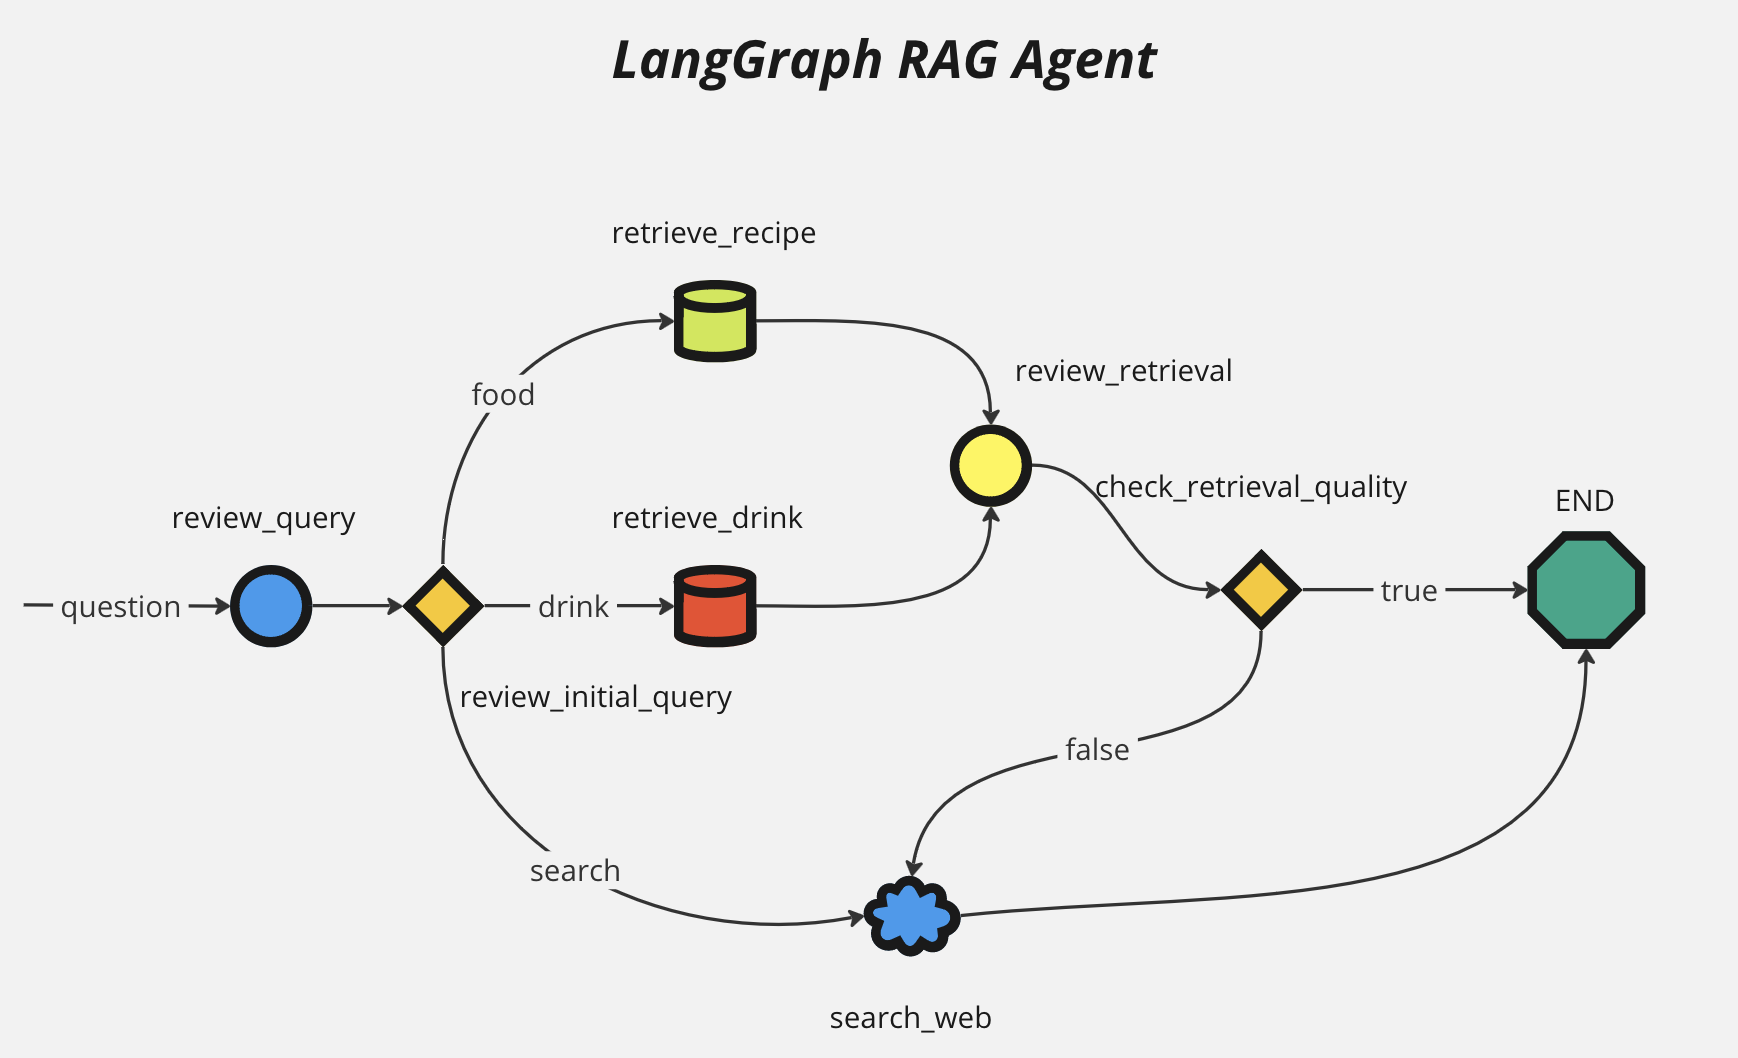

We will use `duckduckgo` search tool as it doesn't require any api keys.

In [28]:
from langchain_community.tools import DuckDuckGoSearchRun
search_tool = DuckDuckGoSearchRun()

Import the necessary modules to build the agent graph.

In [29]:
import langgraph
from langchain_community.chat_models import ChatOllama
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from pydantic import field_validator

Our agent memory will track the following:

1. `question` we receive from the user
2. `context` we retrieve from the vector stores
3. `quality` to track whether retrieval was good or bad
4. `next` to indicate which path to take next
5. `response` to hold the final response

In [30]:
from typing import TypedDict, Sequence, Optional
import operator

class AgentState(TypedDict):
    question: str
    context: Optional[Sequence[str]]
    response: Optional[str]
    steps: Sequence[str]
    quality: bool
    next: str

### Ollama and `format="json"`

Ollama has a neat feature that allows you to specify whether you always expect a `json` response back.  
This becomes really handy when you need structured response back so you can easily use it within your business logic.

For this lab we will need the language model to response in plain text as well as json depending on how we intend to utilize the output.

In [31]:
json_model = ChatOllama(model="llama2",format="json",temperature=0)
text_model = ChatOllama(model="llama2",temperature=0)

### Review Query Node

This node will inspect the question and flag it as either "food", "drink", or "search" related request.

We create a pydantic schema for our `review_query` node. This will help guide the model to provide conforming json response.

In [32]:
class ClassifierOutput(BaseModel):
    output: Optional[str] = Field(description="Valid values are 'food', 'drink', or 'search'")

    # You can add custom validation logic easily with Pydantic.
    @validator("output")
    def valid_review_response(cls, field) -> str:
        if not field in ["food", "drink", "search"]:
            raise ValueError("Invalid response")
        return field

In [33]:
review_prompt = PromptTemplate.from_template("""You are a request classifier.
If the below request is either about recipe for "food" or "drink", the classify it as such.
If the request cannot be classified as either "food" or "drink", then classify it as "search".
Respond in valid json only in the below format and do not include any explanation.

{{
    "output": <food or drink or search>
}}

Request:
{question}

Output:
""")

review_chain = review_prompt | json_model | JsonOutputParser(pydantic_object=ClassifierOutput)

In [34]:
review_chain.invoke({"question":"what is the recipe for chicken biriyani"})

{'output': 'food'}

In [35]:
review_chain.invoke({"question":"mango shake"})

{'output': 'drink'}

In [36]:
review_chain.invoke({"question":"weather"})

{'output': 'search'}

### Review Retrieval Node

This node will inspect the quality of the retrievals we receive from our vector stores and based on relevance score, determine whether the outputs are good or bad.

We create another pydantic schema for this node.

In [37]:
class RatingOutput(BaseModel):
    review: bool = Field(description="Valid values are true or false")

    # You can add custom validation logic easily with Pydantic.
    @validator("review")
    def valid_review_response(cls, field) -> str:
        if not isinstance(field, bool):
            raise ValueError("Invalid response")
        return field

In [38]:
review_retrieval_prompt = PromptTemplate.from_template("""You are a recipe reviewer.
Rate the below recipe against the request and give a rating of "true" or "false" based on whether the recipe satisfies the request.
The recipe MUST be for the food mentioned by name in the request for the rating to be "true".
Be very sure about your rating.

Respond in valid json in the following format:

```json
{{
  "rating": true or false
}}
```

Request:
########

{request}

Recipe:
########

{recipe}

Rating Response:
########
""")

review_retrieval_chain = review_retrieval_prompt | json_model | JsonOutputParser(pydantic_object=RatingOutput)

### Node Functions

In [39]:
def review_query(state: AgentState):
    """ Review the question and determine next action """
    state["next"] = review_chain.invoke({"question":state["question"]})["output"]
    state["steps"] = ["review_query"]
    return state

async def retrieve_recipe(state: AgentState):
    """ Retrieve recipes from recipe store """
    question = state["question"]
    docs = await recipes_db.asimilarity_search_with_relevance_scores(question,score_threshold=0.7)

    state["context"] = list(map(lambda doc: doc[0].page_content, docs))
    state["next"] = ""
    state["steps"].append("retrieve_recipe")
    return state

async def retrieve_drink(state: AgentState):
    """ Retrieve drinks from drink store """
    question = state["question"]
    docs = await drinks_db.asimilarity_search_with_relevance_scores(question,score_threshold=0.7)

    state["context"] = list(map(lambda doc: doc[0].page_content, docs))
    state["next"] = ""
    state["steps"].append("retrieve_drink")
    return state

def review_retrieval(state: AgentState):
    """ Review retrieval and determine next step """
    responses = [review_retrieval_chain.invoke({"request":state["question"],"recipe":recipe}) for recipe in state["context"]]
    ridx = [(idx, response) for idx, response in enumerate(responses) if response["rating"] == True]

    if len(ridx) > 0:
        state["response"] = state["context"][ridx[0][0]]
        state["quality"] = True
    else:
        state["response"] = ""
        state["quality"] = False
    state["context"] = ""
    state["steps"].append("review_retrieval")
    return state

def search_web(state: AgentState):
    """ Search web """
    state["response"] = search_tool.invoke(state["question"])
    state["next"] = ""
    del state["context"]
    state["steps"].append("search_web")
    return state


### Conditional Router Logic

In [40]:
def review_initial_query(state: AgentState):
    """ Review initial query and determine next step """
    return state["next"]

def check_retrieval_quality(state: AgentState):
    """ Review retrieval response and determine whether it is good quality or not """
    return state["quality"]

### Build Agent Graph

In [41]:
from langgraph.graph import StateGraph, END
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("review_query", review_query)
workflow.add_node("retrieve_recipe", retrieve_recipe)
workflow.add_node("retrieve_drink", retrieve_drink)
workflow.add_node("review_retrieval", review_retrieval)
workflow.add_node("search_web", search_web)

workflow.set_entry_point("review_query")

workflow.add_conditional_edges(
    "review_query",
    review_initial_query,
    {
        "food": "retrieve_recipe",
        "drink": "retrieve_drink",
        "search": "search_web",
    }
)

workflow.add_edge("retrieve_recipe","review_retrieval")
workflow.add_edge("retrieve_drink","review_retrieval")

workflow.add_conditional_edges(
    "review_retrieval",
    check_retrieval_quality,
    {
        True: END,
        False: "search_web",
    }
)

workflow.add_edge("search_web", END)

app = workflow.compile()

### Test Runs

In [42]:
await app.ainvoke({"question":"What is the recipe of pineapple chicken"})

{'question': 'What is the recipe of pineapple chicken',
 'context': '',
 'response': 'Baked Pineapple Chicken\n\nIngredients:\n- 1 (20 oz.) can pineapple slices\n- 1 clove garlic, crushed\n- 2 tsp. cornstarch\n- 2 tsp. Worcestershire sauce\n- 2 tsp. Dijon mustard\n- 1 tsp. rosemary, crushed\n- 6 half chicken breasts, boned\n- 1 lemon, thinly sliced\n\nDirections:\n- Drain pineapple; reserve juice.\n- Combine reserved juice with garlic, cornstarch, Worcestershire sauce, mustard and rosemary. Arrange chicken in shallow baking dish on broiler-proof dish, skin side up.\n- Broil until browned.\n- Stir sauce; pour over chicken.\n- Bake at 400° for 30 minutes.',
 'steps': ['review_query', 'retrieve_recipe', 'review_retrieval'],
 'quality': True,
 'next': ''}

In [43]:
await app.ainvoke({"question":"How to make a martini"})

{'question': 'How to make a martini',
 'context': '',
 'response': "Name: One Sip Martini\n\n    Ingredients:\n    [['2.5 cl', 'Ketel One Vodka'], ['0.5 cl', 'Martini Riserva Speciale Ambrato'], ['0.125 cl', 'Fino sherry']]\n\n    Recipe:\n    STIR all ingredients with ice and strain into chilled glass.",
 'steps': ['review_query', 'retrieve_drink', 'review_retrieval'],
 'quality': True,
 'next': ''}

In [44]:
await app.ainvoke({"question":"How to make a Chicken Manchurian with gravy"})

{'question': 'How to make a Chicken Manchurian with gravy',
 'context': '',
 'response': "Chicken Manchurian is a popular Indo-Chinese dish, like chilli chicken and crispy beef, is made with boneless chicken pieces that are deep-fried and then cooked in a tangy and spicy sauce. It is typically served as an appetizer or a side dish with fried rice or hakka noodles. Pin20 Share Yum Chicken Manchurian is a popular Indo-Chinese chicken recipe that pairs deep-fried chicken pieces with a sweet, hot and sour sauce. This fusion dish is often served as an appetizer or pair Manchurian chicken with rice and steamed or stir-fried veggies to make it a complete meal. To make traditional restaurant-style Chicken Manchurian, you first bread and deep fry chicken pieces, then stir fry them in a sweet tomato-based glaze with crushed red pepper flakes, ginger, garlic, and peppers. From start to finish the meal comes together in less than an hour! We're sharing a simplified traditional recipe today. Chicke

In [45]:
await app.ainvoke({"question":"What is the weather in Kauai"})

{'question': 'What is the weather in Kauai',
 'context': None,
 'response': 'The best times to visit Kauai, when considering the weather, crowds, demand, and prices, are the months of April, May, August, September, and early October. Some call these Kauai\'s \'off-season periods\' or the \'shoulder months.\' But there\'s more to cover on this topic before you make a final decision. Today Partly cloudy. Sunrise: 07:11 Sunset: 18:33 Tue 13 Feb 26° 20° Wed 14 Feb 25° 20° Thu 15 Feb 23° 18° Fri 16 Feb 22° 19° Sat 17 Feb 22° 20° Sun 18 Feb 22° 19° Mon 19 Feb Today Tuesday... Like the rest of the Hawaiian archipelago, Kauai has wet and dry seasons. Kauai is also home to one of the wettest spots on the planet (the Waialeale). The extra water is a win, though—Kauai is lush and brimming with tropical flora and fauna, earning it the "Garden Isle" nickname. The rainy season runs from fall through the winter. Pinterest You\'ve made the excellent decision to visit Kauai. But now you have the task o